# Building a simple FX carry trade performance time series

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, floats, dictionaries, lists, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements, loops, and list comprehensions, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a [Bloomberg terminal](https://data.bloomberglp.com/professional/sites/10/LUISS_2018Primer.pdf). If you are using this notebook within BQuant (or BQNT), you may want to use BQL for getting the data.


## Introduction to FX trading

Currency trading, often referred to as foreign exchange (also abriviated often by ForEx or by FX), is the purchasing and selling of currencies in the foreign exchange marketplace. A relatively small number (~34) of currency pairs are responsible for the majority of volume and activity in the FX market. On Bloomberg and in many other platforms, each currency is denoted by three letters. For example, the US Dollar, the Brazilian Real, the Japanese Yen and the Euro are denoted by USD, BRL, JPY and EUR, respectively. So, let's start by creating a list of these three letter tickers, one for each of the currencies we may want to trade:

In [1]:
currencies = [
    'EUR',
    'JPY',
    'GBP',
    'CHF',
    'CAD',
    'AUD',
    'NZD',
    'NOK',
    'SEK',
    'DKK',
    'CZK',
    'HUF',
    'ISK',
    'PLN',
    'SKK',
    'TRY',
    'ZAR',
    'HKD',
    'INR',
    'IDR',
    'PHP',
    'SGD',
    'KRW',
    'CNY',
    'MYR',
    'TWD',
    'THB',
    'ARS',
    'BRL',
    'CLP',
    'COP',
    'MXN',
    'PEN',
    'RUB'
]

###### Spot exchange rates

All currency trading is done in pairs. Unlike the stock market, where you can buy or sell a single stock, you have to buy one currency and sell another currency in the FX market. Hence, what we really trade in FX is a two sided position where you buy, say, the US Dollar and you selll, say, the Brazilian Real. The typical notation in FX trading is to use a six letter code (of the type XXXYYY) for this pairing where XXX is the three letter code for the currency you are buying and YYY is the three letter code for the currency you are selling. Hence, USDBRL denotes a position that is buying the US Dollar and selling the Brazilian Real. On Bloomberg, when this six letter code comes with the sufix 'Curncy' it will give you the data for the spot exachange rate.

A spot exchange rate is the current price level in the market to directly exchange one currency for another, for delivery on the earliest possible value date. Cash delivery for spot currency transactions is usually the standard settlement date of two business days after the transaction date (T+2). For example, if you type 'USDBRL Curncy' on a Bloomberg terminal, this will give you the spot exchange rate of the USD against the BRL which is the number of Brazilian reais you need to buy one US Dollar.

Let's use a list comprehension to create a list of Bloomberg tickers for the different spot exchange rates (all against the US Dollar, i.e, buying the currency and selling the US Dollar):

In [2]:
spot_fx_tickers = [currency + 'USD Curncy' for currency in currencies]
print(spot_fx_tickers)

['EURUSD Curncy', 'JPYUSD Curncy', 'GBPUSD Curncy', 'CHFUSD Curncy', 'CADUSD Curncy', 'AUDUSD Curncy', 'NZDUSD Curncy', 'NOKUSD Curncy', 'SEKUSD Curncy', 'DKKUSD Curncy', 'CZKUSD Curncy', 'HUFUSD Curncy', 'ISKUSD Curncy', 'PLNUSD Curncy', 'SKKUSD Curncy', 'TRYUSD Curncy', 'ZARUSD Curncy', 'HKDUSD Curncy', 'INRUSD Curncy', 'IDRUSD Curncy', 'PHPUSD Curncy', 'SGDUSD Curncy', 'KRWUSD Curncy', 'CNYUSD Curncy', 'MYRUSD Curncy', 'TWDUSD Curncy', 'THBUSD Curncy', 'ARSUSD Curncy', 'BRLUSD Curncy', 'CLPUSD Curncy', 'COPUSD Curncy', 'MXNUSD Curncy', 'PENUSD Curncy', 'RUBUSD Curncy']


Let's now import [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from Bloomberg. Before you do that you need to make sure that the directory where you placed the FinanceHub project is in the python's root directory. 

In [3]:
import sys
sys.path
finance_hub_path_name = r'C:\Users\gsoares\Dropbox\FinanceHub' # change this to your path name
if finance_hub_path_name not in sys.path:
    sys.path.append(finance_hub_path_name) # this will append the FinanceHub folder into the python's root directory if not there
sys.path   

['',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\python36.zip',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\DLLs',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36',
 'C:\\Users\\gsoares\\AppData\\Roaming\\Python\\Python36\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\twixreader-1.0-py3.6.egg',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\gsoares\\AppData\\Roaming\\Python\\Python36\\site-packages\\IPython\\e

If your `finance_hub_path_name` shows up in the sys.path above, you are all good!

In [4]:
from bloomberg import BBG

bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here denoted by bbg
start_date = '1999-01-04'
end_date = '2019-12-04'
spot_fx_data = bbg.fetch_series(securities=spot_fx_tickers,
                               fields='PX_LAST', # This is the Bloomberg field that contains the spot exchange rates data
                               startdate=start_date,
                               enddate=end_date)

To help us visualize the data we will import `matplotlib.pyplot` and then plot the time series:

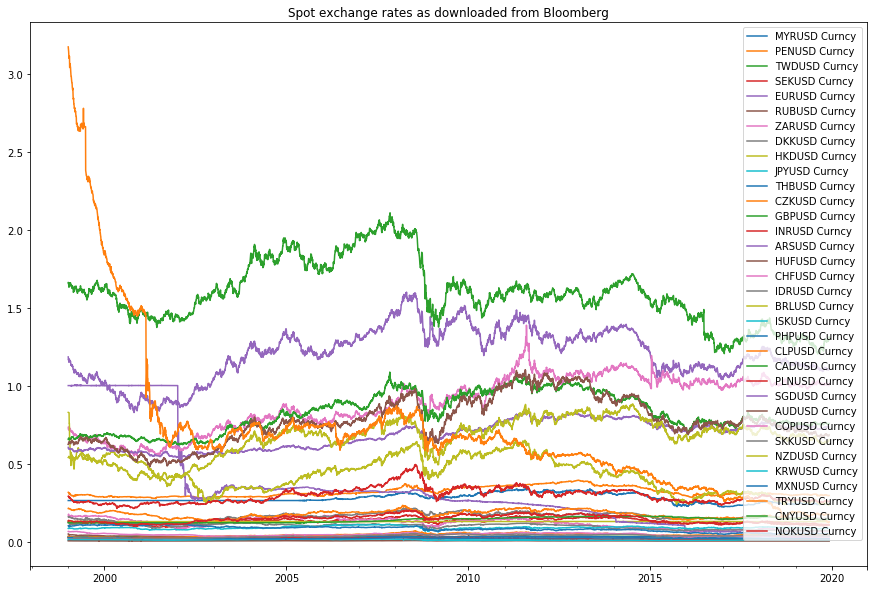

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# this line above is only neeeded when using the matplotlib library in an interactive platform like Jupyter Notebooks
spot_fx_data.plot(title='Spot exchange rates as downloaded from Bloomberg',figsize=(15,10))
plt.show()

## The returns of holding a currency pair

It is very common to see FX trading strategies carried out on spot exchange rates time series like the ones we just downloaded from Bloomberg. However, this is **wrong**!!! This section explains why and it is the most important lesson you will learn in this notebook. It's much more important to understand why it is wrong to create strategies on spot exchange rates that than to learn Python!!

### Spot returns

Suppose, on 2018-11-21, my trading model tells me to buy the Brazilian real and sell the US Dollar, so I would like to buy the BRLUSD on 2018-11-21 So, with 1 US Dollar I buy BRLUSD Brazilian reais on that day:

In [6]:
#First, we define some variables.
trade_date = '2018-11-21'
fx_pair = 'BRLUSD Curncy'
amount_traded_in_usd = 1

In [7]:
# We will use here the pandas the method .loc to get the spot exchange rate for fx_pair on trade_date
p0 = spot_fx_data.loc[trade_date,fx_pair]
p0

0.2633

In [8]:
amount_traded_in_ccy = amount_traded_in_usd/p0
print('On %s I traded %s at the %s level' % (trade_date,fx_pair,p0))
print('On %s I had %s %s and I bought %s %s' % (trade_date,amount_traded_in_usd, fx_pair[3:6],
                                                amount_traded_in_ccy,fx_pair[:3]))

On 2018-11-21 I traded BRLUSD Curncy at the 0.2633 level
On 2018-11-21 I had 1 USD and I bought 3.7979491074819602 BRL


Now, suppose that my trading model tells me to close that position on 2019-12-04. So, I will sell my US Dollars and buy back Brazilian reais. I will do that at the now prevailing exchange rate:

In [9]:
end_date = '2019-12-04'
p1 = spot_fx_data.loc[end_date,fx_pair]
print('On %s I traded %s at the %s level' % (end_date,fx_pair,p1))
print('On %s I had %s %s and I bought %s %s' % (end_date,amount_traded_in_usd/p0,fx_pair[:3], amount_traded_in_ccy*p1,fx_pair[3:6]))

On 2019-12-04 I traded BRLUSD Curncy at the 0.2376 level
On 2019-12-04 I had 3.7979491074819602 BRL and I bought 0.9023927079377138 USD


How much money did I make on this trade?

In [10]:
print('I had %s %s and now I have %s' % (amount_traded_in_usd,fx_pair[3:6],amount_traded_in_ccy*p1))
print('My spot returns were %s percent' % (100*(p1/p0-1)))

I had 1 USD and now I have 0.9023927079377138
My spot returns were -9.760729206228625 percent


### Total returns

Wait! I'm forgetting interest. When I bought BRLUSD Brazilian reais on 2018-11-21, I did not put that money under a mattress. I actually held it in a cash account earning interest. I need to take that into account in my returns. On 2019-12-04, I will have had more Brazilian reais than I initially purchased because I earned interest in it! How much interest? In FX trading, we typically assume that the position in the currency will generate interest according to the so-called *deposit rates*. The deposit interest rate is paid by financial institutions to certificates of deposit (CD), savings accounts, and other types of accounts. Typically, we will use a "depo rate" which refers to interest paid on the interbank market.

Unfortunantly, Bloomberg does not have a consistent way of creating tickers for the deposit rate of each currency. So, we will need a dictionary:

In [11]:
deposit_rates_dict = {
    'EUR': 'EUDRC',
    'JPY': 'JYDRC',
    'GBP': 'BPDRC',
    'CHF': 'SFDRC',
    'CAD': 'CDDRC',
    'AUD': 'ADDRC',
    'NZD': 'NDDRC',
    'NOK': 'NKDRC',
    'SEK': 'SKDRC',
    'DKK': 'DKDRC',
    'CZK': 'CKDRC',
    'HUF': 'HFDRC',
    'ISK': 'IKDRC',
    'PLN': 'PZDRC',
    'SKK': 'VKDRC',
    'TRY': 'TYDRC',
    'ZAR': 'SADRC',
    'HKD': 'HDDRC',
    'INR': 'IRDRC',
    'IDR': 'IHDRC',
    'PHP': 'PPDRC',
    'SGD': 'SDDRC',
    'KRW': 'KWDRC',
    'CNY': 'CCNI3M',
    'MYR': 'MRDRC',
    'TWD': 'NTDRC',
    'THB': 'TBDRC',
    'ARS': 'APDRC',
    'BRL': 'BCDRC',
    'CLP': 'CHDRC',
    'COP': 'CLDRC',
    'MXN': 'MPDRC',
    'PEN': 'PSDRC',
}

In [12]:
ccy = fx_pair[:3]
deposit_rate_ticker = deposit_rates_dict[ccy] + ' BDSR Curncy'
print('The deposit rate for %s has Bloomberg ticker: %s' % (ccy,deposit_rate_ticker))

The deposit rate for BRL has Bloomberg ticker: BCDRC BDSR Curncy


Note that the Russion Ruble is not in our dictionary because it is an exception to the ticker rule we used for all other currencies. Above, we used 'XXX BDSR Curncy' as tickers for the deposit rate of each currency but 'RUB BDSR Curncy' is not the Bloomberg ticker for the Russian Ruble deposit rate. The correct ticker is 'RRDRA Curncy', so we need to modify the code using a if statement:

In [13]:
if ccy not in ['RUB']: 
    deposit_rate_ticker = deposit_rates_dict[ccy] + ' BDSR Curncy'
else:
    deposit_rate_ticker = 'RRDRA Curncy'

Let's use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) to fetch the data on deposit rates:

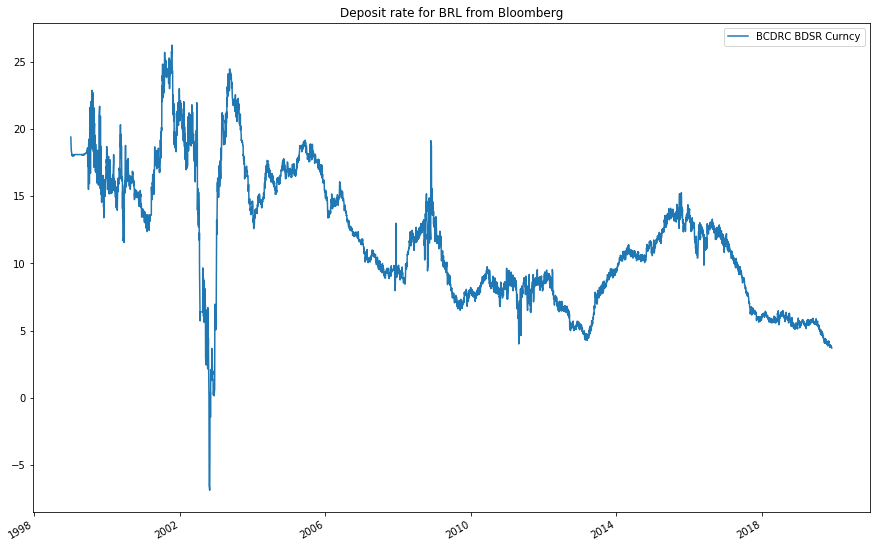

In [14]:
depo_rate_data = bbg.fetch_series(securities=deposit_rate_ticker,
                               fields='PX_LAST', # This is the Bloomberg field that contains the data
                               startdate=start_date,
                               enddate=end_date)
depo_rate_data.plot(title='Deposit rate for %s from Bloomberg' % ccy,figsize=(15,10))
plt.show()

### Constructing a total return index

The total return index tracks both the capital gains/loss of the spot exchange rate but also assumes that the position in the purchased currency earns interest according to the deposit rate. Looking at an index's total return percentage change over two dates, say, between 2018-11-21 and 2019-12-04, we have a more accurate representation of the trade performance over the period. We will store the results in a `Pandas DataFrame` so we need to import pandas first:

In [15]:
import pandas as pd

In [16]:
# let's join the two series, the spot series and the deposit rate series
bbg_raw_data_df = pd.concat([spot_fx_data[[fx_pair]],depo_rate_data],join='outer',axis=1,sort=True)
bbg_raw_data_df = bbg_raw_data_df.fillna(method='ffill').dropna() # drop missing data
bbg_raw_data_df

,BRLUSD Curncy,BCDRC BDSR Curncy
1999-01-04,0.8282,19.390
1999-01-05,0.8278,19.190
1999-01-06,0.8270,18.770
1999-01-07,0.8267,18.600
1999-01-08,0.8264,18.430
1999-01-11,0.8260,18.290
1999-01-12,0.8258,18.150
1999-01-13,0.7576,18.150
1999-01-14,0.7582,18.090
1999-01-15,0.6993,18.010


In [17]:
# let's create a DataFrame that will have the index tracking only spot returns
# and an index tracking the more accurate total return index
df = pd.DataFrame(index=bbg_raw_data_df.index,columns=['spot_index','total_return_index'])
df.iloc[0] = 100. # start both indices at 100
for d in range(1,bbg_raw_data_df.shape[0]): # looping over every day
    
    # spot return is given by the variation on the spot exchange rate alone
    fx_spot_ret = bbg_raw_data_df.iloc[d,0]/bbg_raw_data_df.iloc[d-1,0]
    df['spot_index'].iloc[d] = df['spot_index'].iloc[d-1] * fx_spot_ret
    
    # calculate the interest return for one business day (1/252) using the annualized depo rate from Bloomberg
    interest_return = (bbg_raw_data_df.iloc[d-1,1]/100) / 252 + 1
    
    # "add the two" returns by multiplying them
    total_return = fx_spot_ret*interest_return
    df['total_return_index'].iloc[d] = df['total_return_index'].iloc[d-1]*total_return
    
df = df.fillna(method='ffill').dropna()
df

,spot_index,total_return_index
1999-01-04,100.000000,100.000000
1999-01-05,99.951702,100.028610
1999-01-06,99.855107,100.008039
1999-01-07,99.818884,100.046224
1999-01-08,99.782661,100.083735
1999-01-11,99.734364,100.108453
1999-01-12,99.710215,100.156854
1999-01-13,91.475489,91.951421
1999-01-14,91.547935,92.090523
1999-01-15,84.436127,84.997536


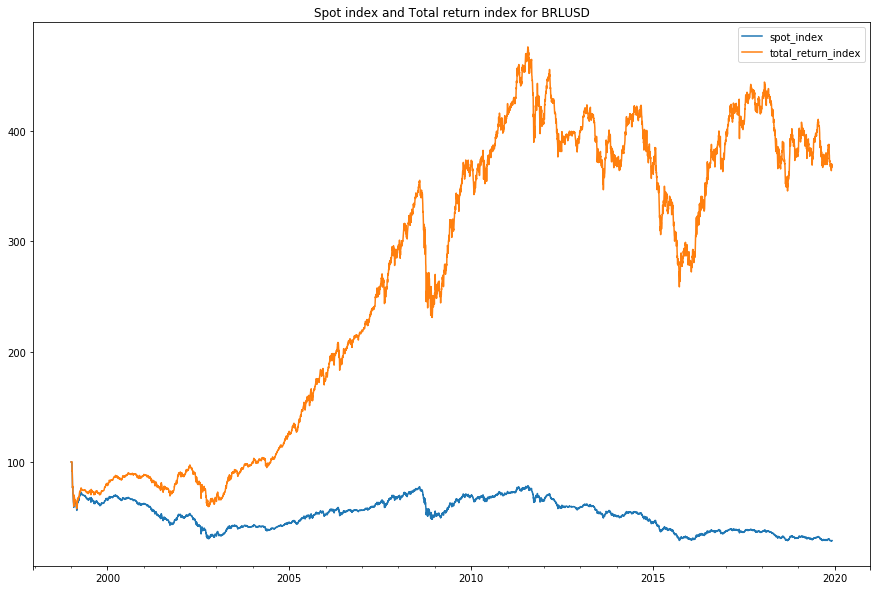

In [18]:
#Finally, let's plot it.
df.plot(title='Spot index and Total return index for %sUSD' % ccy,figsize=(15,10))
plt.show()

Note how different they are. The BRL example illustrates how important it is to take into account interest rate returns when trading FX!

So, how much money did I really make?

In [19]:
s0 = df.loc[trade_date,'spot_index']
s1 = df.loc[end_date,'spot_index']
print('My spot returns were %s percent' % (100*(p1/p0-1)))
tr0 = df.loc[trade_date,'total_return_index']
ts1 = df.loc[end_date,'total_return_index']
print('My actual total returns were %s percent' % (100*(ts1/tr0-1)))

My spot returns were -9.760729206228625 percent
My actual total returns were -4.656708463370773 percent


### Excess returns

In finance, we rarely work with total returns. Most empirical results and trading strategies will be built on excess returns. When I bought BRLUSD Brazilian reais on 2018-11-21, I had to do that with some US Dollars. Where did that come from? If I owned those US Dollars, I am missing out of the cost of opportunity of earning interest on them when I decided to buy BRLs and earn interest on BRL instead. On 2019-12-04, I will have more Brazilian reais than I initially purchased because I earned interest in it in BRL but I could have been earning interest in USD and I did not. Even worse, if I did not own the US Dollars to begin with, I had to borrow them, then I need to pay back with interest. In FX trading, we typically assume that the position in the currency will generate interest according to the so-called *deposit rates* and we take into account the borrowing costs or the cost of opportunity of the funding currency, in this case, the USD.

Let's use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) to fetch the data on USD funding rates:

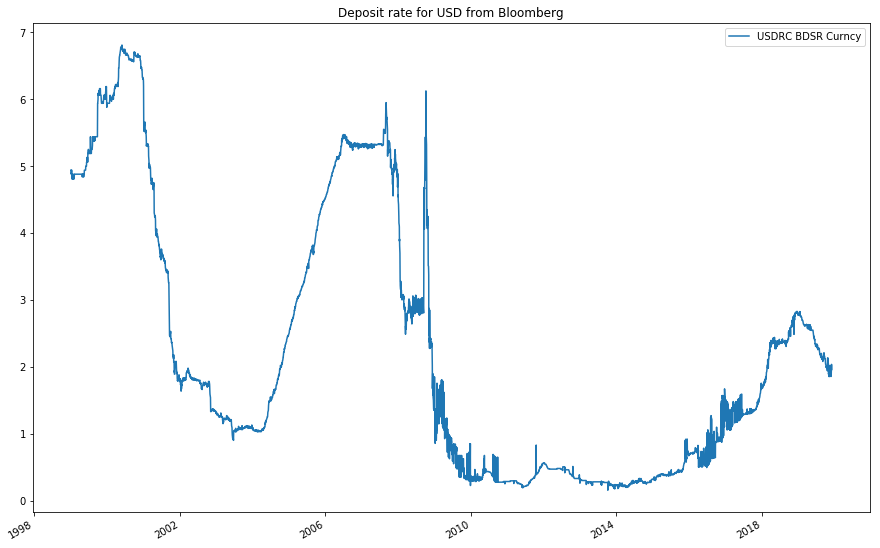

In [20]:
fund_rate_data = bbg.fetch_series(securities='USDRC BDSR Curncy',
                               fields='PX_LAST', # This is the Bloomberg field that contains the data
                               startdate=start_date,
                               enddate=end_date)
fund_rate_data.plot(title='Deposit rate for USD from Bloomberg',figsize=(15,10))
plt.show()

### Constructing an excess return index

The excess return index tracks both the capital gains/loss of the spot exchange rate but also assumes that the position in the purchased currency earns interest according to the deposit rate and the pays interest in the funding currency. Looking at an index's excess return percentage change over two dates, say, between 2018-11-21 and 2019-12-04, we have the representation of the trade performance over the period.

In [21]:
# let's join the three series, the spot series, the deposit rate series, and the funding rate series
bbg_raw_data_df = pd.concat([spot_fx_data[[fx_pair]],depo_rate_data,fund_rate_data],join='outer',axis=1,sort=True)
bbg_raw_data_df = bbg_raw_data_df.fillna(method='ffill').dropna() # drop missing data
bbg_raw_data_df

,BRLUSD Curncy,BCDRC BDSR Curncy,USDRC BDSR Curncy
1999-01-04,0.8282,19.390,4.9400
1999-01-05,0.8278,19.190,4.9400
1999-01-06,0.8270,18.770,4.9400
1999-01-07,0.8267,18.600,4.9400
1999-01-08,0.8264,18.430,4.8800
1999-01-11,0.8260,18.290,4.9400
1999-01-12,0.8258,18.150,4.9400
1999-01-13,0.7576,18.150,4.9400
1999-01-14,0.7582,18.090,4.8800
1999-01-15,0.6993,18.010,4.8100


In [22]:
# let's create a DataFrame that will have the index tracking only spot returns
# an index tracking the  total return index
# an index tracking the excess return index
df = pd.DataFrame(index=bbg_raw_data_df.index,columns=['spot_index','total_return_index','excess_return_index'])
df.iloc[0] = 100. # start both indices at 100
for d in range(1,bbg_raw_data_df.shape[0]): # looping over every day
    
    # spot return is given by the variation on the spot exchange rate alone
    fx_spot_ret = bbg_raw_data_df.iloc[d,0]/bbg_raw_data_df.iloc[d-1,0]
    df['spot_index'].iloc[d] = df['spot_index'].iloc[d-1] * fx_spot_ret
    
    # calculate the interest return for one business day (1/252) using the annualized depo rate from Bloomberg
    interest_return = (bbg_raw_data_df.iloc[d-1,1]/100) / 252 + 1
    
    # "add" the two returns by multiplying them
    total_return = fx_spot_ret*interest_return
    df['total_return_index'].iloc[d] = df['total_return_index'].iloc[d-1]*total_return
    
    # calculate the interest return for one business day (1/252) using the annualized funding rate from Bloomberg
    funding_cost = (bbg_raw_data_df.iloc[d-1,2]/100) / 252 + 1
    
    # "add the two returns and "subtract" the cost by multiplying them
    excess_return = fx_spot_ret*interest_return/funding_cost
    df['excess_return_index'].iloc[d] = df['excess_return_index'].iloc[d-1]*excess_return
    
df = df.fillna(method='ffill').dropna()
df

,spot_index,total_return_index,excess_return_index
1999-01-04,100.000000,100.000000,100.000000
1999-01-05,99.951702,100.028610,100.009005
1999-01-06,99.855107,100.008039,99.968841
1999-01-07,99.818884,100.046224,99.987410
1999-01-08,99.782661,100.083735,100.005295
1999-01-11,99.734364,100.108453,100.010626
1999-01-12,99.710215,100.156854,100.039369
1999-01-13,91.475489,91.951421,91.825560
1999-01-14,91.547935,92.090523,91.946448
1999-01-15,84.436127,84.997536,84.848127


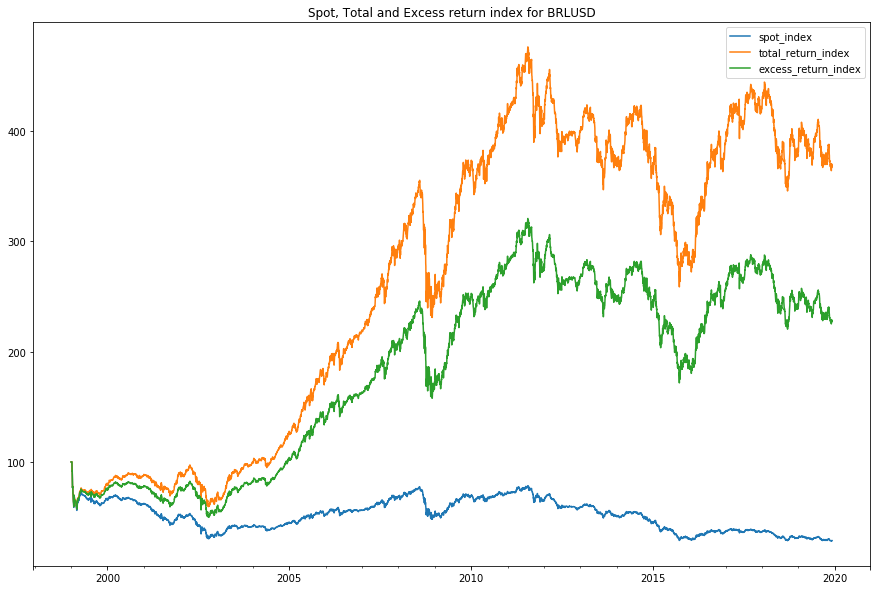

In [23]:
df.plot(title='Spot, Total and Excess return index for %sUSD' % ccy,figsize=(15,10))
plt.show()

So, how much money did I REALLY make?

In [24]:
s0 = df.loc[trade_date,'spot_index']
s1 = df.loc[end_date,'spot_index']
print('My spot returns were %s percent' % (100*(p1/p0-1)))
tr0 = df.loc[trade_date,'total_return_index']
ts1 = df.loc[end_date,'total_return_index']
print('My actual total returns were %s percent' % (100*(ts1/tr0-1)))
er0 = df.loc[trade_date,'excess_return_index']
es1 = df.loc[end_date,'excess_return_index']
print('My actual excess returns were %s percent' % (100*(es1/er0-1)))

My spot returns were -9.760729206228625 percent
My actual total returns were -4.656708463370773 percent
My actual excess returns were -7.100330776516572 percent


### Bloomberg trackers

The nice thing is that Bloomberg calculates these excess return indices already for us. Look how we did a good job in calculating ours:

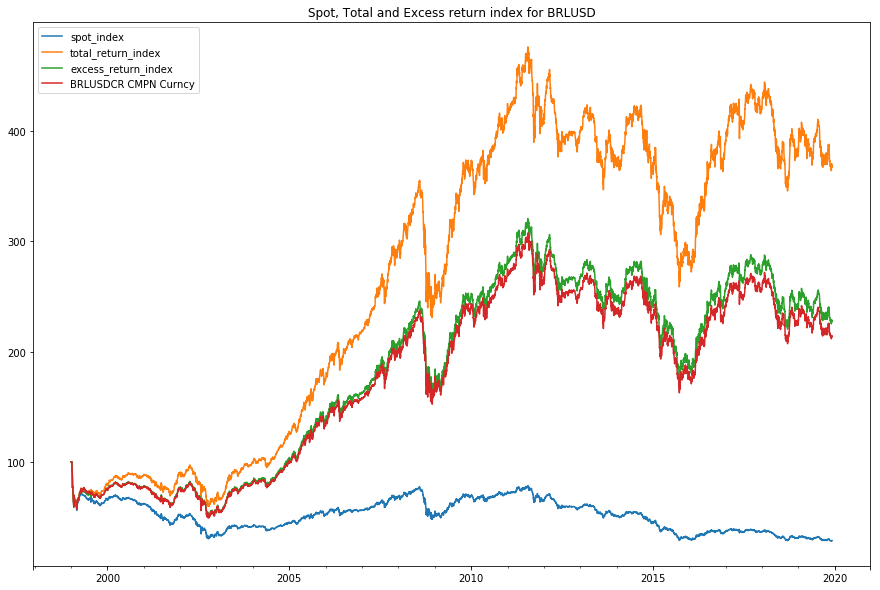

In [25]:
bbg_carry_index = bbg.fetch_series(securities = ccy + 'USDCR CMPN Curncy',
                               fields='PX_LAST',
                               startdate=start_date,
                               enddate=end_date)
df = pd.concat([df,bbg_carry_index],join='outer',axis=1).fillna(method='ffill').dropna()
df.plot(title='Spot, Total and Excess return index for %sUSD' % ccy,figsize=(15,10))
plt.show()

Not perfect but pretty close! The calculation is not perfect because we made a few simplifying assumptions here in this notebook. Going forward! Try to use the Bloomberg carry indices (the ticker is always XXX + 'USDCR CMPN Curncy') as your underlyings when building FX trading strategies!! 
###### Please, never use spot indices or spot exchange rates for creating trading strategies!!

### Exercises

#### Beginners

Take the code into this notebook and try to create a script that plots spot, total and excess return indices for any given currency against the USD.

#### Beginners/Intermediate

Try to see if you can adapt this notebook to use non-Bloomberg data, maybe Yahoo finance or some other publically available financial data source.

#### Intermediate/Advanced

Not all currencies should accrue interest in the same way. Actually, the accrual rule of each Bloomberg deposite rates is very specific. Try to adapt the code in this notebook to correctly accrued deposit and funding rates and see if you can match the Bloomberg trackers more closely.

#### Advanced/Master

Add 'CNH' and 'ILS' to the class of FXCarryTrackers below (all aspects of it, including the metadata part) and a method that correctly accrues deposit and funding rates as described in the Intermediate/Advanced taks above.

#### For Jedi masters

After carrying out the Advanced/Master task above, go to [FinanceHub's FX Tracker Class](https://github.com/Finance-Hub/FinanceHub/blob/master/trackers/FX/fx_tracker.py) and try to make a contribution with the fixes above and create a Jupyter Notebook teaching your fellow FinanceHubbers how to use the class.

In [26]:
class FXCarryTrackers(object):
    # TODO add ['CNH', 'ILS'] to the list of currencies and deposit rates
    currencies = [
        'EUR',
        'JPY',
        'GBP',
        'CHF',
        'CAD',
        'AUD',
        'NZD',
        'NOK',
        'SEK',
        'DKK',
        'CZK',
        'HUF',
        'ISK',
        'PLN',
        'SKK',
        'TRY',
        'ZAR',
        'HKD',
        'INR',
        'IDR',
        'PHP',
        'SGD',
        'KRW',
        'CNY',
        'MYR',
        'TWD',
        'THB',
        'ARS',
        'BRL',
        'CLP',
        'COP',
        'MXN',
        'PEN',
        'RUB'
    ]

    deposit_rates_dict = {
        'EUR': 'EUDRC',
        'JPY': 'JYDRC',
        'GBP': 'BPDRC',
        'CHF': 'SFDRC',
        'CAD': 'CDDRC',
        'AUD': 'ADDRC',
        'NZD': 'NDDRC',
        'NOK': 'NKDRC',
        'SEK': 'SKDRC',
        'DKK': 'DKDRC',
        'CZK': 'CKDRC',
        'HUF': 'HFDRC',
        'ISK': 'IKDRC',
        'PLN': 'PZDRC',
        'SKK': 'VKDRC',
        'TRY': 'TYDRC',
        'ZAR': 'SADRC',
        'HKD': 'HDDRC',
        'INR': 'IRDRC',
        'IDR': 'IHDRC',
        'PHP': 'PPDRC',
        'SGD': 'SDDRC',
        'KRW': 'KWDRC',
        'CNY': 'CCNI3M',
        'MYR': 'MRDRC',
        'TWD': 'NTDRC',
        'THB': 'TBDRC',
        'ARS': 'APDRC',
        'BRL': 'BCDRC',
        'CLP': 'CHDRC',
        'COP': 'CLDRC',
        'MXN': 'MPDRC',
        'PEN': 'PSDRC',
    }

    iso_country_dict = {'AUD': 'AU',
                        'BRL': 'BR',
                        'CAD': 'CA',
                        'CHF': 'CH',
                        'CLP': 'CL',
                        'CZK': 'CZ',
                        'EUR': 'EU',
                        'GBP': 'GB',
                        'HUF': 'HU',
                        'JPY': 'JP',
                        'KRW': 'KR',
                        'MXN': 'MX',
                        'NOK': 'NO',
                        'NZD': 'NZ',
                        'PHP': 'PH',
                        'PLN': 'PL',
                        'SEK': 'SE',
                        'SGD': 'SG',
                        'TRY': 'TR',
                        'TWD': 'TW',
                        'ZAR': 'ZA'}

    quoted_as_XXXUSD = ['BRL', 'CAD', 'CHF', 'CLP', 'CZK', 'HUF', 'JPY', 'KRW', 'MXN', 'NOK',
                        'PHP', 'PLN', 'SGD', 'TRY', 'TWD', 'ZAR', 'SEK']

    def __init__(self, ccy_symbol, start_date='1999-12-31', end_date='today'):
        """
        Returns an object with the following attributes:
            - spot_rate: Series with the spot rate data vs. the USD
            - deposit_rates: Series with the the currency deposit rate and the USD deposite rate
            - er_index: Series with the excess return index
            - ts_df: DataFrame with columns 'Spot', 'ccy_rate', and 'usd_rate'
        :param ccy_symbol: str, Currency symbol from Bloomberg
        :param start_date: str, when the tracker should start
        :param end_date: str, when the tracker should end
        """

        assert ccy_symbol in self.currencies, f'{ccy_symbol} not currently supported'

        self.bbg = BBG()
        self.ccy_symbol = ccy_symbol
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.spot_rate = self._get_spot_rate()
        self.deposit_rates = self._deposit_rates()

        self.country = self.iso_country_dict[self.ccy_symbol]
        self.fh_ticker = 'fx ' + self.country.lower() + ' ' + self.ccy_symbol.lower()
        self.df_metadata = self._get_metadata()

        self.df_tracker = self._calculate_tr_index(self.spot_rate, self.deposit_rates)
        self.df_tracker = self._get_tracker_melted()

    @staticmethod
    def _calculate_tr_index(spot_rate, dep_rates, ann_factor = 252):
        ts_df = pd.concat([spot_rate, dep_rates], axis=1, sort=True).fillna(method='ffill').dropna()

        er_index = pd.Series(index=ts_df.index)
        er_index.iloc[0] = 100.

        for d in er_index.index[1:]:
            fx_spot_ret = ts_df.loc[:d].iloc[-1,0] / ts_df.loc[:d].iloc[-2,0]

            # TODO check if all Bloomberg deposite rates are accrued in the same way
            long_carry_ret = 1 + (ts_df.loc[:d].iloc[-1,1] / 100) / ann_factor
            short_carry_ret = 1 + (ts_df.loc[:d].iloc[-1,2] / 100) / ann_factor
            carry_return = fx_spot_ret * long_carry_ret / short_carry_ret

            er_index[d] = er_index[:d].iloc[-2]*carry_return

        return er_index.to_frame('er_index')

    def _get_spot_rate(self):
        spot_rate_bbg_ticker = self.ccy_symbol + 'USD Curncy'
        bbg_raw_spot_data = self.bbg.fetch_series(securities=spot_rate_bbg_ticker,
                                                  fields='PX_LAST',
                                                  startdate=self.start_date,
                                                  enddate=self.end_date)
        bbg_raw_spot_data.columns = [self.ccy_symbol]
        bbg_raw_spot_data = bbg_raw_spot_data.fillna(method='ffill').dropna()
        return bbg_raw_spot_data

    def _deposit_rates(self):

        usd_dep_rate = self.bbg.fetch_series(securities='USDRC BDSR Curncy',
                                        fields='PX_LAST',
                                        startdate=self.start_date,
                                        enddate=self.end_date)
        usd_dep_rate.columns = ['usd_rate']

        if self.ccy_symbol not in ['RUB']:
            deposit_rate_bbg_ticker = self.deposit_rates_dict[self.ccy_symbol] + ' BDSR Curncy'
        else:
            deposit_rate_bbg_ticker = 'RRDRA Curncy' if self.ccy_symbol == 'RUB' else []

        ccy_dep_rate = self.bbg.fetch_series(securities=deposit_rate_bbg_ticker,
                                        fields='PX_LAST',
                                        startdate=self.start_date,
                                        enddate=self.end_date)
        ccy_dep_rate.columns = [self.ccy_symbol + '_rate']

        dep_rates = pd.concat([ccy_dep_rate,usd_dep_rate],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()

        return dep_rates

    def _get_metadata(self):
        df = pd.DataFrame(index=[0],
                          data={'fh_ticker': self.fh_ticker,
                                'asset_class': 'FX',
                                'type': 'currency forward',
                                'exchange_symbol': self.ccy_symbol,
                                'currency': 'USD',
                                'country': self.country,
                                'maturity': 1/12})
        return df

    def _get_tracker_melted(self):
        df = self.df_tracker[['er_index']].rename({'er_index': self.fh_ticker}, axis=1)
        df['time_stamp'] = df.index.to_series()
        df = df.melt(id_vars='time_stamp', var_name='fh_ticker', value_name='value')
        df = df.dropna()
        return df